In [1]:
%matplotlib inline
# %matplotlib notebook # Does not work 
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import json
from hpbandster.core.result import logged_results_to_HBS_result
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [2]:
def open_hpo_results_files(file):
    with open(file, 'rt') as f_in:
        raw = []
        for line in f_in:
            raw.append(json.loads(line))
        return raw

In [3]:
def load_hpo_results(results_dir):
    results_file = results_dir + 'results.json'
    config_file = results_dir + 'configs.json'
    return {
        'results_lines': open_hpo_results_files(results_file),
        'config_lines': open_hpo_results_files(config_file)        
        }

In [4]:
def load_results(file):
    with open(file, 'rt') as f_in:
        results = []
        for line in f_in:
#             line = line.strip('\n')
            results.append(json.loads(line))
        
        return {'loss_data': [x[3]['loss'] for x in results if x[1] == 100], # Get only runs on 100% of data
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
                'dataset': 'tvqa',
                'hpo_method': file.split('/')[2].split('_')[2],
                'times': [x[2] for x in results]
               }
#         return results

In [5]:
def plot_results(*plots, default=0, n=0, time_flag=False):
        
    plt.figure()
    plt.clf()

    plt.title('RS vs BOHB HPO methods on ' + plots[0]['dataset'].upper() + ' validation set' )
    
    plt.axhline(y=default, color='r', linestyle='-', label = 'Default hp')
    
    for plot_data in plots:
    
        pp = PdfPages(plot_data['dataset'] + '_hpo_curve.pdf')
        pp.savefig()
#         y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
        y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
    
        if time_flag:
            time_diff = plot_data['times'][-1]['finished'] - plot_data['times'][0]['submitted']
            idx = list(np.linspace(0, time_diff, num=len(y_results)))
        
            idx = [x/3600 for x in idx]
            plt.xlabel('wallclock-time [hr]', fontsize = 13)
        else:
            idx = list(range(0,len(y_results)))
            plt.xlabel('# iterations', fontsize = 13)
        
        if plot_data['dataset'] == 'tvqa':            
            plt.ylabel('Loss/Accuracy', fontsize = 13)
        else:
            plt.ylabel('Loss/MAP', fontsize = 13)
        plt.plot(idx[n:], y_results[n:], label = plot_data['hpo_method'].upper())
        
#     plt.plot([x/hour for x in incumbent_bohb['times_finished']], incumbent_bohb['losses'])
    pp.savefig()
    plt.legend()
    plt.show()
    pp.close()

In [6]:
def get_best_config(*results_dirs):
    
    for results_dir in results_dirs:
        results = logged_results_to_HBS_result(results_dir)
        print( {'dir': results_dir,
                'config': results.get_id2config_mapping()[results.get_incumbent_id()]['config'],
                'mean_metric': results.get_runs_by_id(results.get_incumbent_id())[-1].info['mean_metric']
               }, '\n' )

In [7]:
tvqa_bohb_results = './workdir/hpo_results_bohb/results.json'
tvqa_bohb_config = './workdir/hpo_results_bohb/configs.json'
tvqa_rs_results = './workdir/hpo_results_rs/results.json'
tvqa_rs_config = './workdir/hpo_results_rs/configs.json'

In [8]:


tvqa_bohb_results = './workdir/hpo_results_bohb_1573569700/results.json'
tvqa_bohb_config = './workdir/hpo_results_bohb_1573569700/configs.json'
tvqa_rs_results = './workdir/hpo_results_rs_1573569495/results.json'
tvqa_rs_config = './workdir/hpo_results_rs_1573569495/configs.json'

In [9]:
tvqa_bohb_results = load_results(tvqa_bohb_results)
tvqa_rs_results = load_results(tvqa_rs_results)

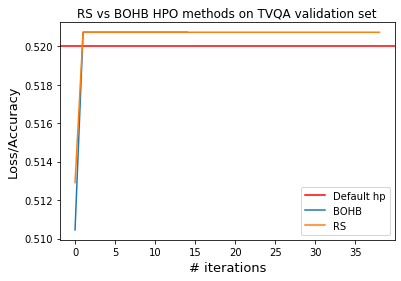

In [10]:
plot_results(tvqa_bohb_results, tvqa_rs_results, default=0.52, n=0, time_flag=False)

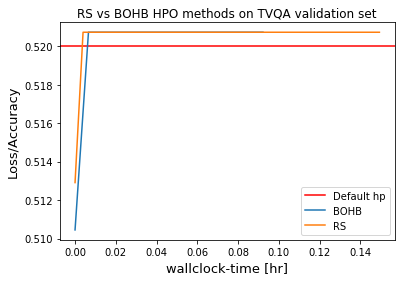

In [11]:
plot_results(tvqa_bohb_results, tvqa_rs_results, default=0.52, n=0, time_flag=True)

In [15]:
now = datetime.now()
timestamp = datetime.timestamp(now)

tvqa_bohb_dir = './workdir/hpo_results_bohb_1573569700/'
tvqa_rs_dir = './workdir/hpo_results_rs_1573569495/'

analyzed_results = {'tvqa_bohb': load_hpo_results(tvqa_bohb_dir),
                    'tvqa_rs': load_hpo_results(tvqa_rs_dir)
                    }

analyzed_results_file = './tvqa_hpo_results_' + str(timestamp) + '.pkl'

pickle.dump( analyzed_results, open(analyzed_results_file, 'wb'))

In [16]:
loaded_results = pickle.load( open( analyzed_results_file, "rb" ))
for k in loaded_results.keys():
    print(loaded_results[k]['results_lines'][0], '\n')

[[0, 0, 0], 33.33333333333333, {'submitted': 1573569700.3701818, 'started': 1573569700.3702343, 'finished': 1573569710.9039266}, {'loss': 0.48902, 'info': {'s': {'metric': 0.51098, 'info': {'label': 'Accuracy based, LambdaMART optimized based on P@1', 'model_file': './workdir/tvqa_lmart_id1_budget33_leaves11_lr0.2_n2'}}, 'mean_metric': 0.51098, 'std_metric': 0.0}}, None] 

[[0, 0, 0], 100, {'submitted': 1573569497.0145588, 'started': 1573569497.0146487, 'finished': 1573569512.7060149}, {'loss': 0.48709, 'info': {'s': {'metric': 0.51291, 'info': {'label': 'Accuracy based, LambdaMART optimized based on P@1', 'model_file': './workdir/tvqa_lmart_id1_budget100_leaves11_lr0.1_n2'}}, 'mean_metric': 0.51291, 'std_metric': 0.0}}, None] 



In [17]:
get_best_config(tvqa_bohb_dir, tvqa_rs_dir)

{'dir': './workdir/hpo_results_bohb_1573569700/', 'config': {'learning_rate': 0.1, 'n_leaves': 10, 'n_trees': 1}, 'mean_metric': 0.52073} 

{'dir': './workdir/hpo_results_rs_1573569495/', 'config': {'learning_rate': 0.1, 'n_leaves': 10, 'n_trees': 1}, 'mean_metric': 0.52073} 

